# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


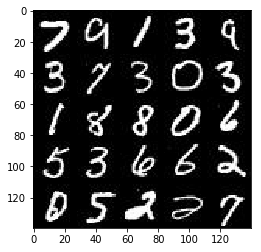

In [ ]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

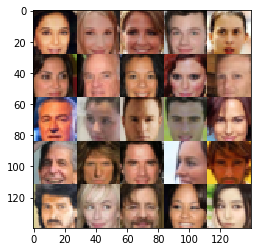

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    inputs_z = tf.placeholder(tf.float32, [None, z_dim])
    learning_rate = tf.placeholder(tf.float32)

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [15]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :param alpha: float value between 0 and 1 to control the "leakiness" of the relu
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    filter_size = 6
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input image is 28x28x(1 or 3)
        # First pass: add some depth
        c1 = tf.layers.conv2d(images, 64, filter_size, strides=1, padding='same')
        relu1 = tf.maximum(alpha * c1, c1)
        
        # Second pass: transform to 14x14x128
        c2 = tf.layers.conv2d(relu1, 128, filter_size, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(c2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        # Second pass transforms to 7x7x256
        c3 = tf.layers.conv2d(relu2, 256, filter_size, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(c3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        # Flatten the final activated convolution
        cflat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(cflat, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [16]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    filter_size = 6
    with tf.variable_scope('generator', reuse=(not is_train)):
        # Pass the input z to a fully connected layer first
        fc1 = tf.layers.dense(z, 7*7*256)
        
        # Reshape to pass to the convolutions
        # Batch normalize and apply leaky relu
        c1 = tf.reshape(fc1, (-1, 7, 7, 256))
        bn1 = tf.layers.batch_normalization(c1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        
        # Image will be 14x14x128
        c2 = tf.layers.conv2d_transpose(relu1, 128, filter_size, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(c2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        # Image will be 28x28x64
        c3 = tf.layers.conv2d_transpose(relu2, 64, filter_size, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(c3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        # Output layer (multiply by 0.5 to scale to the correct range)
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, filter_size, strides=1, padding='same')
        output = tf.tanh(logits)
    
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [17]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # Generate image
    g_output = generator(input_z, out_channel_dim, is_train=True)
    
    # Discrimate on both real and fake image
    d_output_real, d_logits_real = discriminator(input_real, reuse=False)
    d_output_fake, d_logits_fake = discriminator(g_output, reuse=True)
    
    # Loss for real image
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, 
        labels=tf.ones_like(d_output_real)
    ))
    
    # Loss for fake image
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, 
        labels=tf.zeros_like(d_output_fake)
    ))
    
    # Total discriminator loss
    d_loss = d_loss_real + d_loss_fake
    
    # Geneartor loss
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, 
        labels=tf.ones_like(d_output_fake)
    ))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [18]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get the trainables
    trainables = tf.trainable_variables()
    
    # Find variables associated with both the discriminator and the generator via the scope
    dv = [v for v in trainables if v.name.startswith('discriminator')]
    gv = [v for v in trainables if v.name.startswith('generator')]
    
    # Optimize using adam
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_op = tf.train.AdamOptimizer(
            learning_rate,
            beta1=beta1
        ).minimize(
            d_loss,
            var_list=dv
        )
        
        g_train_op = tf.train.AdamOptimizer(
            learning_rate,
            beta1=beta1
        ).minimize(
            g_loss,
            var_list=gv
        )
    return d_train_op, g_train_op


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [24]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # Determine the number of channels for the image
    if data_image_mode == 'RGB':
        image_channels = 3
    elif data_image_mode == 'L':
        image_channels = 1
    else:
        raise "data_image_mode has to be either RGB or L"
    
    # Width and height
    image_width, image_height = data_shape[1], data_shape[2]
    
    # Inputs placeholders
    input_real, input_z, lrate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # Losses
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # Optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, lrate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1 
                
                # Normalize between -1 and 1
                batch_images *= 2
                
                # Random noise for the generator (batch_size, z_dim)
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run the optimizers
                _ = sess.run(d_opt, feed_dict={
                    input_real: batch_images,
                    input_z: batch_z,
                    lrate: learning_rate
                })
                
                # Run the generator multiple times for each pass since it trains more
                # Slowly
                for gi in range(2):
                    _ = sess.run(g_opt, feed_dict={
                        input_real: batch_images,
                        input_z: batch_z,
                        lrate: learning_rate
                    })
                
                # Print the losses
                if steps % 10 == 0:
                    d_loss_train = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    g_loss_train = g_loss.eval({input_z: batch_z})
                    
                    msg = "Epoch {}/{}; d_loss: {:.4f}; g_loss: {:.4f}".format(
                        epoch_i+1, epoch_count, d_loss_train, g_loss_train
                    )
                    print(msg)
                    
                # View samples
                if steps % 100 == 0:
                    # The generator output
                    show_generator_output(sess, 36, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2; d_loss: 4.3205; g_loss: 0.1168
Epoch 1/2; d_loss: 3.3920; g_loss: 0.1140
Epoch 1/2; d_loss: 3.6359; g_loss: 0.0482
Epoch 1/2; d_loss: 3.0770; g_loss: 0.0787
Epoch 1/2; d_loss: 3.0697; g_loss: 0.0665
Epoch 1/2; d_loss: 2.4934; g_loss: 0.1348
Epoch 1/2; d_loss: 2.5326; g_loss: 0.0999
Epoch 1/2; d_loss: 2.6131; g_loss: 0.0890
Epoch 1/2; d_loss: 2.1322; g_loss: 0.1969
Epoch 1/2; d_loss: 2.3374; g_loss: 0.1430


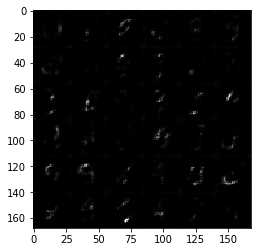

Epoch 1/2; d_loss: 2.2526; g_loss: 0.1461
Epoch 1/2; d_loss: 1.9680; g_loss: 0.2302
Epoch 1/2; d_loss: 2.4009; g_loss: 0.1168
Epoch 1/2; d_loss: 1.7098; g_loss: 0.2991
Epoch 1/2; d_loss: 1.8096; g_loss: 0.2854
Epoch 1/2; d_loss: 1.6518; g_loss: 0.3253
Epoch 1/2; d_loss: 2.0624; g_loss: 0.2110
Epoch 1/2; d_loss: 2.7347; g_loss: 0.0938
Epoch 1/2; d_loss: 1.8117; g_loss: 0.2533
Epoch 1/2; d_loss: 2.1684; g_loss: 0.2957


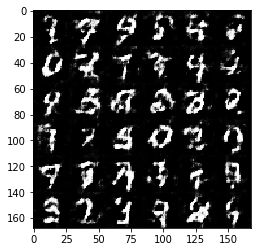

Epoch 1/2; d_loss: 1.8484; g_loss: 0.3006
Epoch 1/2; d_loss: 1.7647; g_loss: 0.3660
Epoch 1/2; d_loss: 1.8498; g_loss: 0.4509
Epoch 1/2; d_loss: 2.6035; g_loss: 0.1033
Epoch 1/2; d_loss: 2.4108; g_loss: 0.1180
Epoch 1/2; d_loss: 2.6560; g_loss: 0.0862
Epoch 1/2; d_loss: 1.9767; g_loss: 0.4572
Epoch 1/2; d_loss: 2.1377; g_loss: 0.1589
Epoch 1/2; d_loss: 2.0970; g_loss: 0.6392
Epoch 1/2; d_loss: 1.8265; g_loss: 0.2553


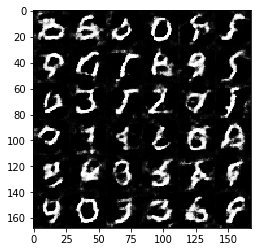

Epoch 1/2; d_loss: 1.7405; g_loss: 0.3372
Epoch 1/2; d_loss: 2.1665; g_loss: 0.1538
Epoch 1/2; d_loss: 2.0206; g_loss: 0.2041
Epoch 1/2; d_loss: 1.5792; g_loss: 0.4207
Epoch 1/2; d_loss: 1.7080; g_loss: 0.8292
Epoch 1/2; d_loss: 2.3080; g_loss: 0.1400
Epoch 1/2; d_loss: 2.2681; g_loss: 0.1733
Epoch 1/2; d_loss: 1.8416; g_loss: 0.4132
Epoch 1/2; d_loss: 1.8206; g_loss: 0.2777
Epoch 1/2; d_loss: 1.7174; g_loss: 0.3087


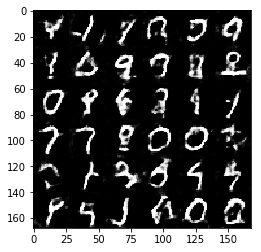

Epoch 1/2; d_loss: 2.3346; g_loss: 0.1427
Epoch 1/2; d_loss: 2.2759; g_loss: 0.1432
Epoch 1/2; d_loss: 1.5617; g_loss: 0.6058
Epoch 1/2; d_loss: 1.7088; g_loss: 0.4540
Epoch 1/2; d_loss: 1.8140; g_loss: 0.3164
Epoch 1/2; d_loss: 1.8347; g_loss: 0.2580
Epoch 1/2; d_loss: 1.5283; g_loss: 0.7245
Epoch 1/2; d_loss: 1.8180; g_loss: 0.4441
Epoch 1/2; d_loss: 1.7280; g_loss: 0.5248
Epoch 1/2; d_loss: 1.7080; g_loss: 0.3480


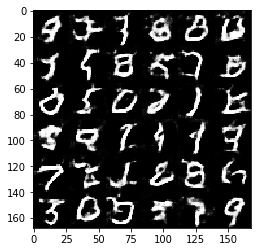

Epoch 1/2; d_loss: 1.3951; g_loss: 0.5094
Epoch 1/2; d_loss: 2.1254; g_loss: 1.3244
Epoch 1/2; d_loss: 1.5922; g_loss: 0.4628
Epoch 1/2; d_loss: 1.6198; g_loss: 0.5753
Epoch 1/2; d_loss: 1.5428; g_loss: 0.3206
Epoch 1/2; d_loss: 2.8634; g_loss: 1.1991
Epoch 1/2; d_loss: 1.9212; g_loss: 0.2343
Epoch 1/2; d_loss: 1.7664; g_loss: 0.2796
Epoch 1/2; d_loss: 1.6709; g_loss: 0.3070
Epoch 1/2; d_loss: 2.4553; g_loss: 0.1128


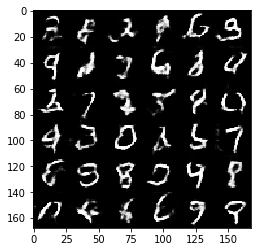

Epoch 1/2; d_loss: 1.3776; g_loss: 0.4758
Epoch 1/2; d_loss: 1.7236; g_loss: 0.2584
Epoch 1/2; d_loss: 2.0994; g_loss: 0.1762
Epoch 1/2; d_loss: 1.3324; g_loss: 0.5600
Epoch 1/2; d_loss: 1.8108; g_loss: 0.2405
Epoch 1/2; d_loss: 1.6034; g_loss: 0.3906
Epoch 1/2; d_loss: 1.6257; g_loss: 0.3333
Epoch 1/2; d_loss: 1.6836; g_loss: 0.3106
Epoch 1/2; d_loss: 1.7138; g_loss: 0.2517
Epoch 1/2; d_loss: 1.7610; g_loss: 0.2725


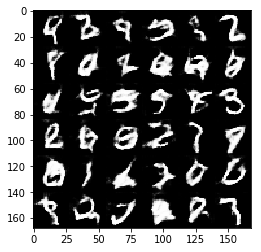

Epoch 1/2; d_loss: 1.3097; g_loss: 0.6345
Epoch 1/2; d_loss: 1.6110; g_loss: 0.3808
Epoch 1/2; d_loss: 1.1654; g_loss: 0.9400
Epoch 1/2; d_loss: 1.4090; g_loss: 1.2399
Epoch 1/2; d_loss: 1.5088; g_loss: 0.3538
Epoch 1/2; d_loss: 1.5156; g_loss: 0.4778
Epoch 1/2; d_loss: 1.5528; g_loss: 0.4994
Epoch 1/2; d_loss: 1.4340; g_loss: 0.4926
Epoch 1/2; d_loss: 1.5081; g_loss: 0.8866
Epoch 1/2; d_loss: 1.5114; g_loss: 0.4813


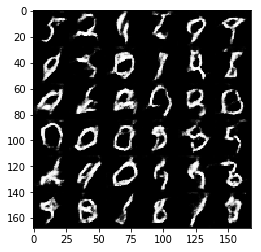

Epoch 1/2; d_loss: 1.2036; g_loss: 0.7637
Epoch 1/2; d_loss: 1.2600; g_loss: 0.6823
Epoch 1/2; d_loss: 1.4642; g_loss: 0.3754
Epoch 1/2; d_loss: 1.7247; g_loss: 1.0747
Epoch 1/2; d_loss: 1.6404; g_loss: 0.3353
Epoch 1/2; d_loss: 1.2812; g_loss: 0.7503
Epoch 1/2; d_loss: 2.2369; g_loss: 0.1535
Epoch 1/2; d_loss: 1.5388; g_loss: 0.3211
Epoch 1/2; d_loss: 1.5611; g_loss: 0.4412
Epoch 1/2; d_loss: 1.4293; g_loss: 0.3870


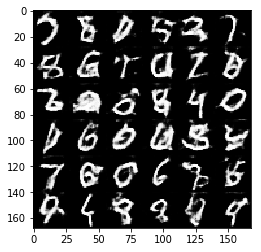

Epoch 1/2; d_loss: 1.4095; g_loss: 0.4048
Epoch 1/2; d_loss: 2.8973; g_loss: 0.0772
Epoch 1/2; d_loss: 1.5910; g_loss: 0.3539
Epoch 1/2; d_loss: 1.1345; g_loss: 0.7355
Epoch 1/2; d_loss: 1.5895; g_loss: 0.3090
Epoch 1/2; d_loss: 1.4714; g_loss: 0.4688
Epoch 1/2; d_loss: 1.8824; g_loss: 0.2083
Epoch 1/2; d_loss: 1.5742; g_loss: 0.5733
Epoch 1/2; d_loss: 1.6893; g_loss: 0.2745
Epoch 1/2; d_loss: 1.3657; g_loss: 0.5638


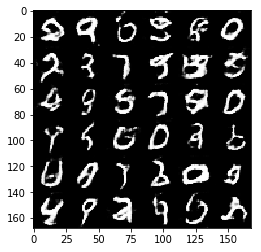

Epoch 1/2; d_loss: 1.8551; g_loss: 0.2307
Epoch 1/2; d_loss: 1.3280; g_loss: 0.4582
Epoch 1/2; d_loss: 1.6470; g_loss: 0.3163
Epoch 1/2; d_loss: 1.4396; g_loss: 0.4292
Epoch 1/2; d_loss: 2.5573; g_loss: 0.1142
Epoch 1/2; d_loss: 1.7943; g_loss: 0.2354
Epoch 1/2; d_loss: 2.1791; g_loss: 0.1469
Epoch 1/2; d_loss: 1.6984; g_loss: 0.5294
Epoch 1/2; d_loss: 1.7395; g_loss: 0.2579
Epoch 1/2; d_loss: 2.3448; g_loss: 2.3971


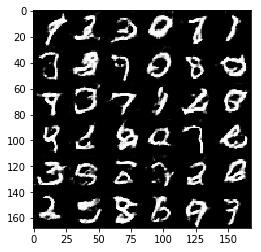

Epoch 1/2; d_loss: 1.8094; g_loss: 0.2385
Epoch 1/2; d_loss: 1.3643; g_loss: 0.4591
Epoch 1/2; d_loss: 1.8966; g_loss: 0.2144
Epoch 1/2; d_loss: 1.3988; g_loss: 0.7532
Epoch 1/2; d_loss: 1.9168; g_loss: 0.2147
Epoch 1/2; d_loss: 1.5993; g_loss: 0.4012
Epoch 1/2; d_loss: 1.3654; g_loss: 0.8466
Epoch 1/2; d_loss: 1.5934; g_loss: 0.3749
Epoch 1/2; d_loss: 1.6835; g_loss: 0.3029
Epoch 1/2; d_loss: 1.5907; g_loss: 0.3284


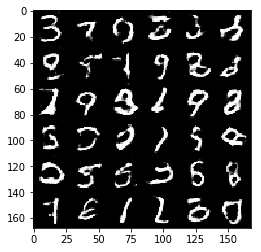

Epoch 1/2; d_loss: 2.1749; g_loss: 0.2009
Epoch 1/2; d_loss: 1.5239; g_loss: 0.4945
Epoch 1/2; d_loss: 1.4955; g_loss: 0.3972
Epoch 1/2; d_loss: 1.2825; g_loss: 0.6459
Epoch 1/2; d_loss: 1.4163; g_loss: 0.6933
Epoch 1/2; d_loss: 1.9583; g_loss: 0.2167
Epoch 1/2; d_loss: 1.7208; g_loss: 0.3598
Epoch 1/2; d_loss: 0.9676; g_loss: 1.1237
Epoch 1/2; d_loss: 2.8433; g_loss: 0.0874
Epoch 1/2; d_loss: 1.5024; g_loss: 0.5030


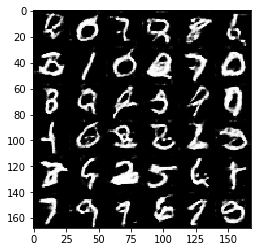

Epoch 1/2; d_loss: 1.4365; g_loss: 0.3754
Epoch 1/2; d_loss: 1.3216; g_loss: 0.6114
Epoch 1/2; d_loss: 2.0805; g_loss: 0.1684
Epoch 1/2; d_loss: 1.2900; g_loss: 0.4524
Epoch 1/2; d_loss: 1.1327; g_loss: 0.6157
Epoch 1/2; d_loss: 1.8297; g_loss: 0.2184
Epoch 1/2; d_loss: 1.5737; g_loss: 0.3506
Epoch 1/2; d_loss: 1.1634; g_loss: 0.6158
Epoch 1/2; d_loss: 1.9891; g_loss: 0.1958
Epoch 1/2; d_loss: 1.1124; g_loss: 0.7742


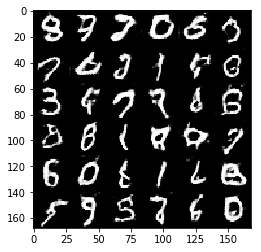

Epoch 1/2; d_loss: 2.0668; g_loss: 2.4983
Epoch 1/2; d_loss: 1.0930; g_loss: 1.2002
Epoch 1/2; d_loss: 1.4280; g_loss: 0.4305
Epoch 1/2; d_loss: 1.3312; g_loss: 0.6509
Epoch 1/2; d_loss: 1.3187; g_loss: 0.4318
Epoch 1/2; d_loss: 1.3484; g_loss: 0.4843
Epoch 1/2; d_loss: 1.2581; g_loss: 0.4657
Epoch 1/2; d_loss: 1.6074; g_loss: 0.3086
Epoch 1/2; d_loss: 2.3597; g_loss: 0.1280
Epoch 1/2; d_loss: 1.1644; g_loss: 1.5356


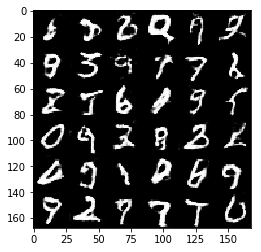

Epoch 1/2; d_loss: 2.0738; g_loss: 0.2109
Epoch 1/2; d_loss: 0.9780; g_loss: 1.2584
Epoch 1/2; d_loss: 1.9565; g_loss: 0.2372
Epoch 1/2; d_loss: 1.5388; g_loss: 0.3734
Epoch 1/2; d_loss: 2.2548; g_loss: 0.1506
Epoch 1/2; d_loss: 1.0708; g_loss: 0.7847
Epoch 1/2; d_loss: 1.2533; g_loss: 0.5075
Epoch 1/2; d_loss: 1.6140; g_loss: 0.3183
Epoch 1/2; d_loss: 1.5263; g_loss: 0.3316
Epoch 1/2; d_loss: 1.4998; g_loss: 0.5255


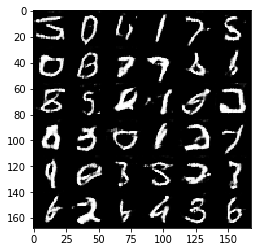

Epoch 1/2; d_loss: 2.7942; g_loss: 0.0820
Epoch 1/2; d_loss: 1.2517; g_loss: 0.5513
Epoch 1/2; d_loss: 1.4158; g_loss: 0.5340
Epoch 1/2; d_loss: 1.5975; g_loss: 0.3469
Epoch 1/2; d_loss: 1.1600; g_loss: 0.5158
Epoch 1/2; d_loss: 1.6982; g_loss: 0.2940
Epoch 1/2; d_loss: 1.8033; g_loss: 0.2434
Epoch 1/2; d_loss: 1.7266; g_loss: 0.2795
Epoch 1/2; d_loss: 1.6161; g_loss: 0.3151
Epoch 1/2; d_loss: 1.7155; g_loss: 0.2588


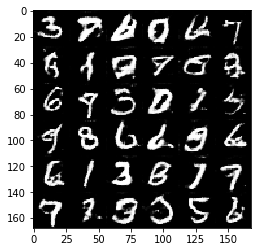

Epoch 1/2; d_loss: 1.7496; g_loss: 0.2476
Epoch 1/2; d_loss: 1.1987; g_loss: 0.5924
Epoch 1/2; d_loss: 1.3820; g_loss: 1.8169
Epoch 1/2; d_loss: 1.4620; g_loss: 0.3880
Epoch 1/2; d_loss: 1.0075; g_loss: 1.0009
Epoch 1/2; d_loss: 1.6845; g_loss: 0.2986
Epoch 1/2; d_loss: 0.7593; g_loss: 0.9700
Epoch 1/2; d_loss: 1.8767; g_loss: 2.5693
Epoch 1/2; d_loss: 1.2830; g_loss: 0.4858
Epoch 1/2; d_loss: 2.3015; g_loss: 0.1562


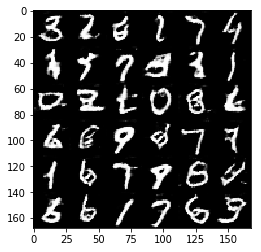

Epoch 1/2; d_loss: 1.5873; g_loss: 0.3642
Epoch 1/2; d_loss: 1.2958; g_loss: 0.4370
Epoch 1/2; d_loss: 1.5049; g_loss: 0.3638
Epoch 1/2; d_loss: 1.2024; g_loss: 0.5405
Epoch 1/2; d_loss: 2.0666; g_loss: 0.2240
Epoch 1/2; d_loss: 1.5428; g_loss: 0.3377
Epoch 1/2; d_loss: 2.1151; g_loss: 0.1782
Epoch 2/2; d_loss: 1.5126; g_loss: 0.3218
Epoch 2/2; d_loss: 3.3667; g_loss: 3.9872
Epoch 2/2; d_loss: 1.2574; g_loss: 1.3531


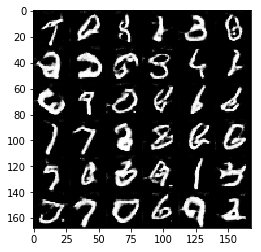

Epoch 2/2; d_loss: 0.9597; g_loss: 1.1898
Epoch 2/2; d_loss: 1.1868; g_loss: 0.4860
Epoch 2/2; d_loss: 1.1535; g_loss: 0.6319
Epoch 2/2; d_loss: 1.1646; g_loss: 0.5273
Epoch 2/2; d_loss: 2.2674; g_loss: 0.1726
Epoch 2/2; d_loss: 0.9062; g_loss: 0.8206
Epoch 2/2; d_loss: 1.3469; g_loss: 0.4164
Epoch 2/2; d_loss: 1.3640; g_loss: 0.4688
Epoch 2/2; d_loss: 1.8077; g_loss: 0.3034
Epoch 2/2; d_loss: 1.3738; g_loss: 0.3500


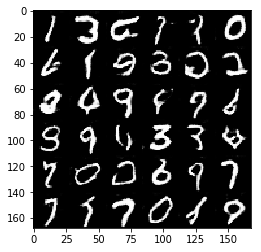

Epoch 2/2; d_loss: 0.9007; g_loss: 1.0147
Epoch 2/2; d_loss: 1.0354; g_loss: 0.7670
Epoch 2/2; d_loss: 1.4370; g_loss: 0.3610
Epoch 2/2; d_loss: 1.5056; g_loss: 0.3859
Epoch 2/2; d_loss: 2.7185; g_loss: 0.1074
Epoch 2/2; d_loss: 1.0348; g_loss: 0.8582
Epoch 2/2; d_loss: 1.5642; g_loss: 0.3248
Epoch 2/2; d_loss: 1.2329; g_loss: 0.6897
Epoch 2/2; d_loss: 1.2732; g_loss: 0.6875
Epoch 2/2; d_loss: 1.5768; g_loss: 0.4195


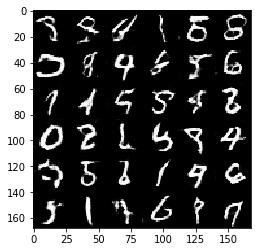

Epoch 2/2; d_loss: 1.4936; g_loss: 2.1038
Epoch 2/2; d_loss: 1.0303; g_loss: 0.7656
Epoch 2/2; d_loss: 0.8605; g_loss: 0.7723
Epoch 2/2; d_loss: 0.8866; g_loss: 0.9098
Epoch 2/2; d_loss: 1.3216; g_loss: 0.6090
Epoch 2/2; d_loss: 1.5364; g_loss: 0.3813
Epoch 2/2; d_loss: 1.0245; g_loss: 0.7869
Epoch 2/2; d_loss: 1.2092; g_loss: 0.5321
Epoch 2/2; d_loss: 0.8333; g_loss: 1.9597
Epoch 2/2; d_loss: 1.1602; g_loss: 1.4891


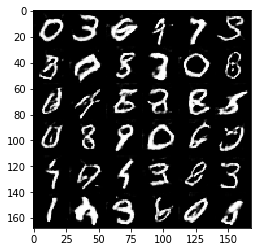

Epoch 2/2; d_loss: 0.7832; g_loss: 1.1712
Epoch 2/2; d_loss: 1.6896; g_loss: 0.2853
Epoch 2/2; d_loss: 1.6253; g_loss: 0.3031
Epoch 2/2; d_loss: 1.1985; g_loss: 0.4747
Epoch 2/2; d_loss: 1.6011; g_loss: 0.2647
Epoch 2/2; d_loss: 2.4316; g_loss: 3.6955
Epoch 2/2; d_loss: 0.9627; g_loss: 0.9191
Epoch 2/2; d_loss: 1.4996; g_loss: 0.3544
Epoch 2/2; d_loss: 1.5222; g_loss: 0.3389
Epoch 2/2; d_loss: 1.2035; g_loss: 0.8254


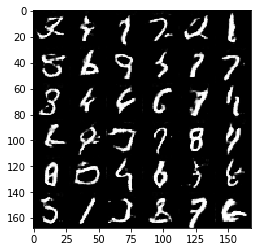

Epoch 2/2; d_loss: 1.3824; g_loss: 0.4563
Epoch 2/2; d_loss: 0.9592; g_loss: 0.6729
Epoch 2/2; d_loss: 1.3170; g_loss: 0.4996
Epoch 2/2; d_loss: 1.0735; g_loss: 0.5883
Epoch 2/2; d_loss: 1.3676; g_loss: 0.5570
Epoch 2/2; d_loss: 1.1646; g_loss: 0.5078
Epoch 2/2; d_loss: 1.2759; g_loss: 0.4968
Epoch 2/2; d_loss: 0.8366; g_loss: 1.1813
Epoch 2/2; d_loss: 1.3675; g_loss: 0.4137
Epoch 2/2; d_loss: 1.2239; g_loss: 0.4623


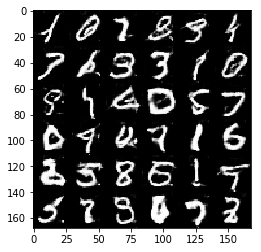

Epoch 2/2; d_loss: 0.9597; g_loss: 1.1086
Epoch 2/2; d_loss: 1.2001; g_loss: 0.5611
Epoch 2/2; d_loss: 1.3936; g_loss: 0.4359
Epoch 2/2; d_loss: 1.4732; g_loss: 0.3342
Epoch 2/2; d_loss: 1.5942; g_loss: 0.3807
Epoch 2/2; d_loss: 1.5004; g_loss: 0.3636
Epoch 2/2; d_loss: 1.0495; g_loss: 0.9513
Epoch 2/2; d_loss: 0.9548; g_loss: 0.9211
Epoch 2/2; d_loss: 1.7527; g_loss: 0.2682
Epoch 2/2; d_loss: 1.2730; g_loss: 2.7571


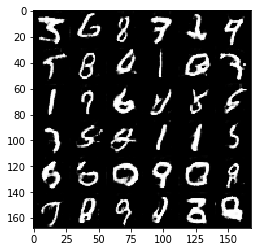

Epoch 2/2; d_loss: 1.3877; g_loss: 0.4259
Epoch 2/2; d_loss: 0.8947; g_loss: 1.6967
Epoch 2/2; d_loss: 2.7837; g_loss: 0.0799
Epoch 2/2; d_loss: 1.7460; g_loss: 0.2705
Epoch 2/2; d_loss: 0.9293; g_loss: 0.8898
Epoch 2/2; d_loss: 1.0628; g_loss: 0.7068
Epoch 2/2; d_loss: 1.3448; g_loss: 0.4701
Epoch 2/2; d_loss: 0.8444; g_loss: 0.8910
Epoch 2/2; d_loss: 1.1568; g_loss: 1.9837
Epoch 2/2; d_loss: 1.1908; g_loss: 0.5957


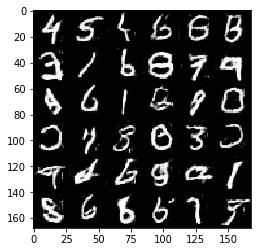

Epoch 2/2; d_loss: 1.4173; g_loss: 0.4022
Epoch 2/2; d_loss: 1.7258; g_loss: 0.3062
Epoch 2/2; d_loss: 1.8381; g_loss: 0.2995
Epoch 2/2; d_loss: 1.2937; g_loss: 0.5049
Epoch 2/2; d_loss: 2.6902; g_loss: 0.1182
Epoch 2/2; d_loss: 1.5601; g_loss: 3.2059
Epoch 2/2; d_loss: 1.2410; g_loss: 0.5027
Epoch 2/2; d_loss: 1.6257; g_loss: 0.3145
Epoch 2/2; d_loss: 1.7302; g_loss: 0.2590
Epoch 2/2; d_loss: 1.3242; g_loss: 0.5397


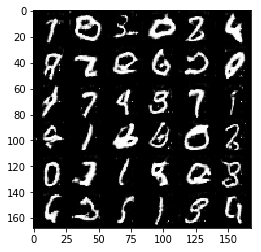

Epoch 2/2; d_loss: 1.2924; g_loss: 0.5399
Epoch 2/2; d_loss: 1.6758; g_loss: 0.2670
Epoch 2/2; d_loss: 1.3575; g_loss: 2.7811
Epoch 2/2; d_loss: 1.4117; g_loss: 0.4456
Epoch 2/2; d_loss: 2.0656; g_loss: 0.2127
Epoch 2/2; d_loss: 0.9214; g_loss: 1.7562
Epoch 2/2; d_loss: 1.4771; g_loss: 0.3759
Epoch 2/2; d_loss: 1.3307; g_loss: 0.5595
Epoch 2/2; d_loss: 1.5697; g_loss: 0.3762
Epoch 2/2; d_loss: 0.8344; g_loss: 2.3763


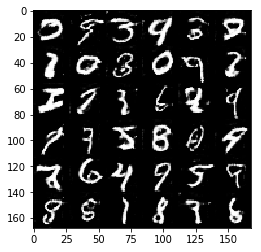

Epoch 2/2; d_loss: 0.6921; g_loss: 1.2635
Epoch 2/2; d_loss: 1.3171; g_loss: 0.4458
Epoch 2/2; d_loss: 1.3395; g_loss: 0.4632
Epoch 2/2; d_loss: 1.2965; g_loss: 0.4381
Epoch 2/2; d_loss: 0.9767; g_loss: 1.4383
Epoch 2/2; d_loss: 1.6605; g_loss: 0.3298
Epoch 2/2; d_loss: 1.9286; g_loss: 0.2634
Epoch 2/2; d_loss: 1.2012; g_loss: 0.5405
Epoch 2/2; d_loss: 1.4331; g_loss: 0.8143
Epoch 2/2; d_loss: 1.3880; g_loss: 0.4836


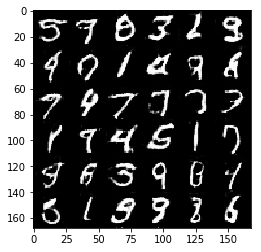

Epoch 2/2; d_loss: 1.2094; g_loss: 0.5336
Epoch 2/2; d_loss: 0.7377; g_loss: 1.4409
Epoch 2/2; d_loss: 1.0170; g_loss: 0.7895
Epoch 2/2; d_loss: 1.1760; g_loss: 0.5212
Epoch 2/2; d_loss: 1.5629; g_loss: 0.3603
Epoch 2/2; d_loss: 1.1420; g_loss: 0.6485
Epoch 2/2; d_loss: 1.0578; g_loss: 0.6268
Epoch 2/2; d_loss: 2.3410; g_loss: 0.1742
Epoch 2/2; d_loss: 2.7337; g_loss: 0.1180
Epoch 2/2; d_loss: 0.9713; g_loss: 1.0542


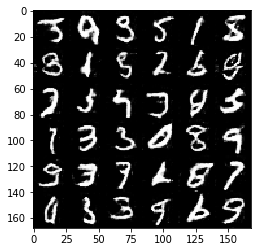

Epoch 2/2; d_loss: 0.7195; g_loss: 1.4890
Epoch 2/2; d_loss: 1.6824; g_loss: 0.2799
Epoch 2/2; d_loss: 1.6511; g_loss: 0.3048
Epoch 2/2; d_loss: 1.3989; g_loss: 0.4899
Epoch 2/2; d_loss: 2.8525; g_loss: 0.1039
Epoch 2/2; d_loss: 0.6287; g_loss: 1.7270
Epoch 2/2; d_loss: 2.2186; g_loss: 0.1704
Epoch 2/2; d_loss: 1.1106; g_loss: 0.5819
Epoch 2/2; d_loss: 1.1551; g_loss: 2.5521
Epoch 2/2; d_loss: 1.5827; g_loss: 0.3502


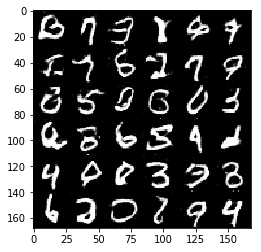

Epoch 2/2; d_loss: 1.5748; g_loss: 0.3406
Epoch 2/2; d_loss: 0.4811; g_loss: 1.3267
Epoch 2/2; d_loss: 1.6829; g_loss: 0.3596
Epoch 2/2; d_loss: 0.8828; g_loss: 0.8170
Epoch 2/2; d_loss: 1.8784; g_loss: 0.2797
Epoch 2/2; d_loss: 1.3400; g_loss: 0.4987
Epoch 2/2; d_loss: 1.7462; g_loss: 0.3247
Epoch 2/2; d_loss: 0.8394; g_loss: 2.2009
Epoch 2/2; d_loss: 1.2588; g_loss: 0.5079
Epoch 2/2; d_loss: 0.9788; g_loss: 0.7705


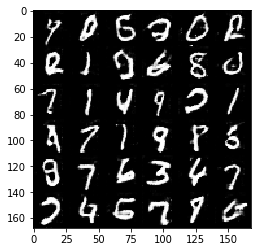

Epoch 2/2; d_loss: 2.0753; g_loss: 0.2290
Epoch 2/2; d_loss: 4.1955; g_loss: 5.6448
Epoch 2/2; d_loss: 0.7635; g_loss: 1.2590
Epoch 2/2; d_loss: 1.9317; g_loss: 0.2595
Epoch 2/2; d_loss: 0.4480; g_loss: 1.5464
Epoch 2/2; d_loss: 1.7531; g_loss: 0.2836
Epoch 2/2; d_loss: 1.2232; g_loss: 0.5116
Epoch 2/2; d_loss: 1.7402; g_loss: 0.3055
Epoch 2/2; d_loss: 2.0321; g_loss: 0.2355
Epoch 2/2; d_loss: 1.6552; g_loss: 0.2685


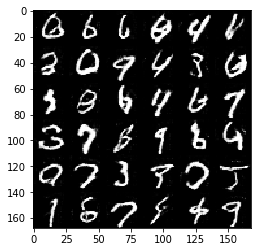

Epoch 2/2; d_loss: 1.2850; g_loss: 0.4806
Epoch 2/2; d_loss: 0.4554; g_loss: 1.4867
Epoch 2/2; d_loss: 1.0616; g_loss: 0.5859
Epoch 2/2; d_loss: 1.0639; g_loss: 0.6855
Epoch 2/2; d_loss: 0.3898; g_loss: 1.5587
Epoch 2/2; d_loss: 2.0056; g_loss: 0.1785
Epoch 2/2; d_loss: 1.4428; g_loss: 3.7254
Epoch 2/2; d_loss: 1.1327; g_loss: 0.6038
Epoch 2/2; d_loss: 0.3708; g_loss: 2.8166
Epoch 2/2; d_loss: 1.4353; g_loss: 0.3481


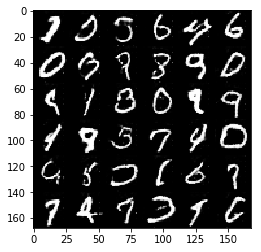

Epoch 2/2; d_loss: 1.6623; g_loss: 0.3257
Epoch 2/2; d_loss: 0.8081; g_loss: 0.8815
Epoch 2/2; d_loss: 0.6582; g_loss: 1.3796
Epoch 2/2; d_loss: 1.1624; g_loss: 0.5696
Epoch 2/2; d_loss: 1.7374; g_loss: 0.2788
Epoch 2/2; d_loss: 1.5974; g_loss: 0.3168
Epoch 2/2; d_loss: 0.8949; g_loss: 0.7258
Epoch 2/2; d_loss: 2.5673; g_loss: 0.1157
Epoch 2/2; d_loss: 0.7129; g_loss: 1.5837
Epoch 2/2; d_loss: 0.8558; g_loss: 0.9099


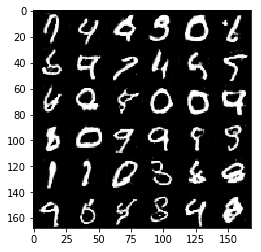

Epoch 2/2; d_loss: 0.9906; g_loss: 1.8570
Epoch 2/2; d_loss: 1.0530; g_loss: 0.6304
Epoch 2/2; d_loss: 1.3356; g_loss: 0.5103
Epoch 2/2; d_loss: 1.3948; g_loss: 0.4815
Epoch 2/2; d_loss: 1.5362; g_loss: 0.3485
Epoch 2/2; d_loss: 2.7972; g_loss: 0.0963
Epoch 2/2; d_loss: 1.0244; g_loss: 0.7793
Epoch 2/2; d_loss: 1.2962; g_loss: 0.4940
Epoch 2/2; d_loss: 1.8911; g_loss: 0.2953
Epoch 2/2; d_loss: 0.9114; g_loss: 1.6109


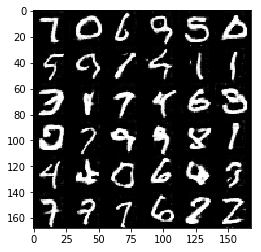

Epoch 2/2; d_loss: 0.9875; g_loss: 2.2222
Epoch 2/2; d_loss: 0.8388; g_loss: 1.7497
Epoch 2/2; d_loss: 1.1580; g_loss: 1.0840
Epoch 2/2; d_loss: 1.9927; g_loss: 0.2202
Epoch 2/2; d_loss: 1.7374; g_loss: 0.3314
Epoch 2/2; d_loss: 1.2319; g_loss: 0.6021
Epoch 2/2; d_loss: 1.2491; g_loss: 0.5589
Epoch 2/2; d_loss: 1.0627; g_loss: 0.6667
Epoch 2/2; d_loss: 0.8729; g_loss: 3.3731
Epoch 2/2; d_loss: 0.6201; g_loss: 1.7275


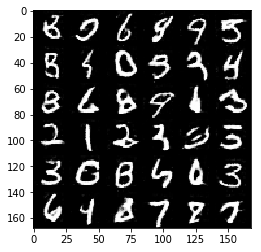

Epoch 2/2; d_loss: 1.6712; g_loss: 0.3496
Epoch 2/2; d_loss: 1.8671; g_loss: 0.2959
Epoch 2/2; d_loss: 2.3427; g_loss: 0.1420
Epoch 2/2; d_loss: 2.4129; g_loss: 0.1628
Epoch 2/2; d_loss: 0.9495; g_loss: 1.2618


In [25]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3

# Reset the default graph to start with a clean slate
tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1; d_loss: 5.3667; g_loss: 0.0058
Epoch 1/1; d_loss: 5.5327; g_loss: 0.0066
Epoch 1/1; d_loss: 2.7695; g_loss: 0.1907
Epoch 1/1; d_loss: 2.3279; g_loss: 0.1698
Epoch 1/1; d_loss: 1.7345; g_loss: 1.2014
Epoch 1/1; d_loss: 3.0152; g_loss: 0.0723
Epoch 1/1; d_loss: 2.2289; g_loss: 0.2171
Epoch 1/1; d_loss: 1.2308; g_loss: 1.4852
Epoch 1/1; d_loss: 2.1962; g_loss: 2.0051
Epoch 1/1; d_loss: 2.3994; g_loss: 0.1384


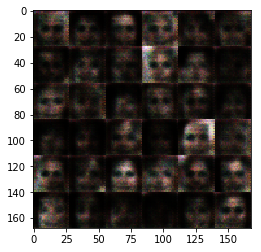

Epoch 1/1; d_loss: 2.4298; g_loss: 0.1185
Epoch 1/1; d_loss: 0.5952; g_loss: 1.1701
Epoch 1/1; d_loss: 1.7455; g_loss: 0.3173
Epoch 1/1; d_loss: 1.4862; g_loss: 0.6180
Epoch 1/1; d_loss: 2.4624; g_loss: 0.1236
Epoch 1/1; d_loss: 2.2725; g_loss: 0.1626
Epoch 1/1; d_loss: 1.6005; g_loss: 0.5472
Epoch 1/1; d_loss: 0.6348; g_loss: 1.4755
Epoch 1/1; d_loss: 1.1225; g_loss: 1.0918
Epoch 1/1; d_loss: 2.1669; g_loss: 0.1450


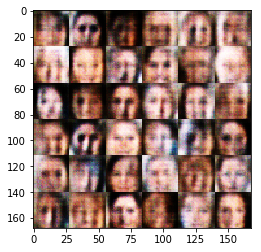

Epoch 1/1; d_loss: 1.3467; g_loss: 0.5176
Epoch 1/1; d_loss: 1.6295; g_loss: 0.5876
Epoch 1/1; d_loss: 3.0792; g_loss: 0.0704
Epoch 1/1; d_loss: 1.8226; g_loss: 1.9829
Epoch 1/1; d_loss: 2.7253; g_loss: 0.1084
Epoch 1/1; d_loss: 2.3009; g_loss: 0.1503
Epoch 1/1; d_loss: 1.3169; g_loss: 0.9287
Epoch 1/1; d_loss: 2.2368; g_loss: 0.1479
Epoch 1/1; d_loss: 2.3072; g_loss: 0.1478
Epoch 1/1; d_loss: 2.1312; g_loss: 0.1897


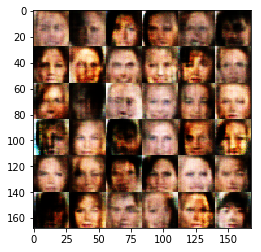

Epoch 1/1; d_loss: 0.7355; g_loss: 1.4018
Epoch 1/1; d_loss: 2.7392; g_loss: 0.0913
Epoch 1/1; d_loss: 2.4556; g_loss: 0.1198
Epoch 1/1; d_loss: 1.2604; g_loss: 0.7976
Epoch 1/1; d_loss: 2.2357; g_loss: 0.1474
Epoch 1/1; d_loss: 2.1487; g_loss: 0.1669
Epoch 1/1; d_loss: 1.7044; g_loss: 0.2793
Epoch 1/1; d_loss: 1.6951; g_loss: 0.2947
Epoch 1/1; d_loss: 1.9339; g_loss: 0.2239
Epoch 1/1; d_loss: 2.1663; g_loss: 0.1538


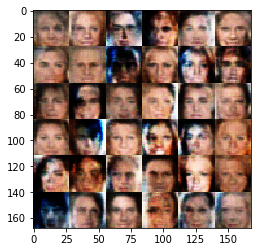

Epoch 1/1; d_loss: 2.3024; g_loss: 0.1645
Epoch 1/1; d_loss: 1.5476; g_loss: 1.6356
Epoch 1/1; d_loss: 1.1411; g_loss: 0.8759
Epoch 1/1; d_loss: 1.5640; g_loss: 0.4714
Epoch 1/1; d_loss: 1.2943; g_loss: 1.3174
Epoch 1/1; d_loss: 1.3644; g_loss: 0.5786
Epoch 1/1; d_loss: 1.5858; g_loss: 0.2966
Epoch 1/1; d_loss: 1.2882; g_loss: 0.5720
Epoch 1/1; d_loss: 0.8301; g_loss: 2.6405
Epoch 1/1; d_loss: 1.2794; g_loss: 0.5049


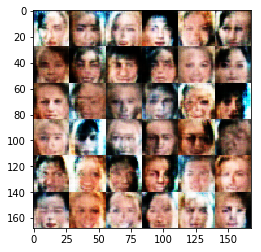

Epoch 1/1; d_loss: 0.8167; g_loss: 2.8397
Epoch 1/1; d_loss: 0.7023; g_loss: 3.4142
Epoch 1/1; d_loss: 1.0959; g_loss: 1.9470
Epoch 1/1; d_loss: 0.2383; g_loss: 2.1079
Epoch 1/1; d_loss: 0.3476; g_loss: 1.5907
Epoch 1/1; d_loss: 0.8242; g_loss: 0.8064
Epoch 1/1; d_loss: 0.4190; g_loss: 4.7267
Epoch 1/1; d_loss: 0.8125; g_loss: 0.7856
Epoch 1/1; d_loss: 2.5699; g_loss: 0.0956
Epoch 1/1; d_loss: 1.3288; g_loss: 0.4235


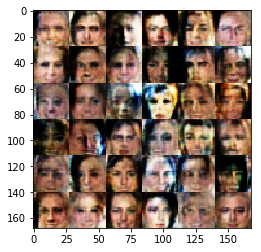

Epoch 1/1; d_loss: 0.5979; g_loss: 1.3360
Epoch 1/1; d_loss: 2.0988; g_loss: 0.1891
Epoch 1/1; d_loss: 0.3873; g_loss: 2.0811
Epoch 1/1; d_loss: 0.1529; g_loss: 3.1450
Epoch 1/1; d_loss: 0.5566; g_loss: 0.9977
Epoch 1/1; d_loss: 0.9205; g_loss: 0.6128
Epoch 1/1; d_loss: 0.5597; g_loss: 5.6315
Epoch 1/1; d_loss: 0.3654; g_loss: 1.8157
Epoch 1/1; d_loss: 0.1273; g_loss: 3.1830
Epoch 1/1; d_loss: 0.3783; g_loss: 1.4461


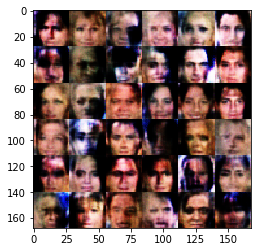

Epoch 1/1; d_loss: 1.7596; g_loss: 0.2702
Epoch 1/1; d_loss: 1.8970; g_loss: 0.5401
Epoch 1/1; d_loss: 1.3033; g_loss: 0.6524
Epoch 1/1; d_loss: 1.1826; g_loss: 0.5221
Epoch 1/1; d_loss: 2.6517; g_loss: 0.1175
Epoch 1/1; d_loss: 1.0490; g_loss: 0.6171
Epoch 1/1; d_loss: 0.5228; g_loss: 1.4489
Epoch 1/1; d_loss: 0.1485; g_loss: 2.5644
Epoch 1/1; d_loss: 0.8493; g_loss: 1.2127
Epoch 1/1; d_loss: 1.6205; g_loss: 0.2883


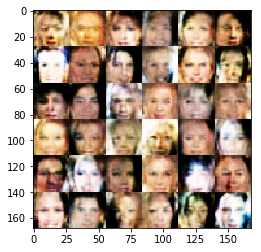

Epoch 1/1; d_loss: 0.4501; g_loss: 3.7298
Epoch 1/1; d_loss: 3.5571; g_loss: 0.0361
Epoch 1/1; d_loss: 1.3519; g_loss: 0.4842
Epoch 1/1; d_loss: 1.3408; g_loss: 1.5339
Epoch 1/1; d_loss: 0.2352; g_loss: 3.0212
Epoch 1/1; d_loss: 1.1911; g_loss: 0.4747
Epoch 1/1; d_loss: 0.5635; g_loss: 1.3463
Epoch 1/1; d_loss: 0.2545; g_loss: 2.0688
Epoch 1/1; d_loss: 1.2682; g_loss: 0.6762
Epoch 1/1; d_loss: 0.9911; g_loss: 0.7363


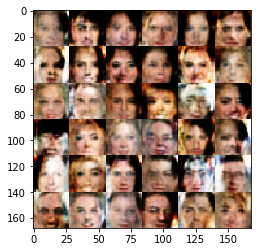

Epoch 1/1; d_loss: 0.8308; g_loss: 1.3528
Epoch 1/1; d_loss: 1.0220; g_loss: 0.6157
Epoch 1/1; d_loss: 0.8725; g_loss: 1.3157
Epoch 1/1; d_loss: 1.1450; g_loss: 0.4590
Epoch 1/1; d_loss: 0.4867; g_loss: 1.2387
Epoch 1/1; d_loss: 1.4718; g_loss: 0.4552
Epoch 1/1; d_loss: 0.9633; g_loss: 0.7376
Epoch 1/1; d_loss: 0.7105; g_loss: 1.8691
Epoch 1/1; d_loss: 0.6787; g_loss: 1.0572
Epoch 1/1; d_loss: 2.0271; g_loss: 0.1911


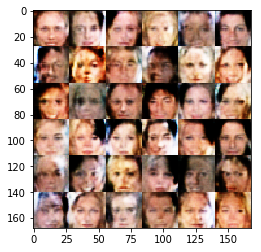

Epoch 1/1; d_loss: 1.2793; g_loss: 0.4339
Epoch 1/1; d_loss: 1.7818; g_loss: 0.2392
Epoch 1/1; d_loss: 1.0069; g_loss: 0.7131
Epoch 1/1; d_loss: 1.0171; g_loss: 0.5723
Epoch 1/1; d_loss: 0.2600; g_loss: 1.9574
Epoch 1/1; d_loss: 0.9468; g_loss: 0.6989
Epoch 1/1; d_loss: 0.7131; g_loss: 1.6962
Epoch 1/1; d_loss: 2.5345; g_loss: 0.1145
Epoch 1/1; d_loss: 0.2916; g_loss: 1.7709
Epoch 1/1; d_loss: 1.0689; g_loss: 2.9661


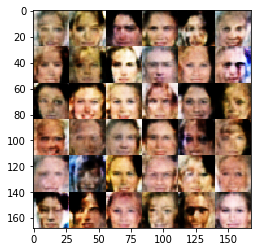

Epoch 1/1; d_loss: 0.5847; g_loss: 2.0432
Epoch 1/1; d_loss: 2.1935; g_loss: 3.9290
Epoch 1/1; d_loss: 1.3858; g_loss: 0.3619
Epoch 1/1; d_loss: 0.8971; g_loss: 0.7378
Epoch 1/1; d_loss: 1.1608; g_loss: 0.5215
Epoch 1/1; d_loss: 0.8120; g_loss: 2.1871
Epoch 1/1; d_loss: 1.9065; g_loss: 0.1954
Epoch 1/1; d_loss: 0.6591; g_loss: 2.3649
Epoch 1/1; d_loss: 1.1205; g_loss: 0.5224
Epoch 1/1; d_loss: 1.7842; g_loss: 0.2295


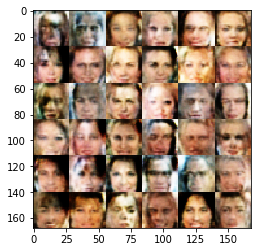

Epoch 1/1; d_loss: 0.5795; g_loss: 2.4476
Epoch 1/1; d_loss: 0.4749; g_loss: 1.7040
Epoch 1/1; d_loss: 1.1982; g_loss: 2.2912
Epoch 1/1; d_loss: 2.1581; g_loss: 0.1476
Epoch 1/1; d_loss: 0.6085; g_loss: 1.2794
Epoch 1/1; d_loss: 1.8527; g_loss: 0.2339
Epoch 1/1; d_loss: 0.2733; g_loss: 4.1761
Epoch 1/1; d_loss: 1.0199; g_loss: 0.5548
Epoch 1/1; d_loss: 1.3386; g_loss: 0.3952
Epoch 1/1; d_loss: 0.4662; g_loss: 1.6373


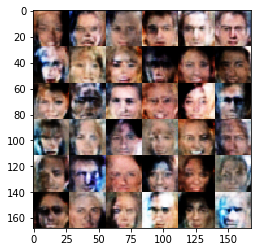

Epoch 1/1; d_loss: 1.1589; g_loss: 2.0681
Epoch 1/1; d_loss: 2.6761; g_loss: 0.0858
Epoch 1/1; d_loss: 0.9237; g_loss: 1.3319
Epoch 1/1; d_loss: 1.2768; g_loss: 0.4817
Epoch 1/1; d_loss: 0.6497; g_loss: 1.2239
Epoch 1/1; d_loss: 1.2392; g_loss: 0.4345
Epoch 1/1; d_loss: 0.6922; g_loss: 0.9768
Epoch 1/1; d_loss: 1.0402; g_loss: 0.5481
Epoch 1/1; d_loss: 2.5433; g_loss: 0.1361
Epoch 1/1; d_loss: 1.2409; g_loss: 0.4281


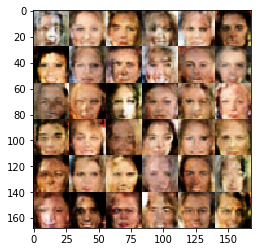

Epoch 1/1; d_loss: 1.2204; g_loss: 0.4831
Epoch 1/1; d_loss: 0.8436; g_loss: 1.2284
Epoch 1/1; d_loss: 0.9213; g_loss: 0.9412
Epoch 1/1; d_loss: 0.9425; g_loss: 0.6888
Epoch 1/1; d_loss: 1.0653; g_loss: 2.5547
Epoch 1/1; d_loss: 0.8633; g_loss: 1.8565
Epoch 1/1; d_loss: 0.9871; g_loss: 1.9165
Epoch 1/1; d_loss: 3.0520; g_loss: 4.9118
Epoch 1/1; d_loss: 0.6678; g_loss: 1.1170
Epoch 1/1; d_loss: 2.3097; g_loss: 0.1309


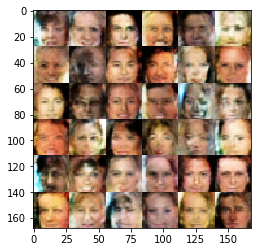

Epoch 1/1; d_loss: 0.4735; g_loss: 1.5728
Epoch 1/1; d_loss: 1.5601; g_loss: 0.3122
Epoch 1/1; d_loss: 0.8696; g_loss: 1.5172
Epoch 1/1; d_loss: 3.3552; g_loss: 0.0520
Epoch 1/1; d_loss: 0.8625; g_loss: 0.8974
Epoch 1/1; d_loss: 1.5871; g_loss: 0.3883
Epoch 1/1; d_loss: 0.4499; g_loss: 2.7429
Epoch 1/1; d_loss: 1.1759; g_loss: 0.5083
Epoch 1/1; d_loss: 1.7223; g_loss: 1.0409
Epoch 1/1; d_loss: 1.0736; g_loss: 0.5536


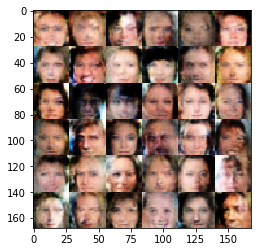

Epoch 1/1; d_loss: 1.1423; g_loss: 0.6854
Epoch 1/1; d_loss: 0.7964; g_loss: 2.8909
Epoch 1/1; d_loss: 1.2651; g_loss: 1.2815
Epoch 1/1; d_loss: 0.6690; g_loss: 2.7253
Epoch 1/1; d_loss: 0.4123; g_loss: 2.4545
Epoch 1/1; d_loss: 0.8770; g_loss: 1.3716
Epoch 1/1; d_loss: 0.5332; g_loss: 3.3157
Epoch 1/1; d_loss: 1.4315; g_loss: 0.4287
Epoch 1/1; d_loss: 1.3613; g_loss: 0.3737
Epoch 1/1; d_loss: 0.8366; g_loss: 0.7060


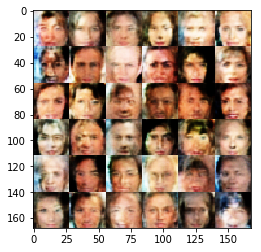

Epoch 1/1; d_loss: 2.0991; g_loss: 0.2890
Epoch 1/1; d_loss: 1.8850; g_loss: 0.2441
Epoch 1/1; d_loss: 0.8171; g_loss: 1.8674
Epoch 1/1; d_loss: 1.5128; g_loss: 0.3641
Epoch 1/1; d_loss: 1.1041; g_loss: 0.6611
Epoch 1/1; d_loss: 0.7173; g_loss: 1.7524
Epoch 1/1; d_loss: 1.6299; g_loss: 0.3052
Epoch 1/1; d_loss: 0.5066; g_loss: 3.4428
Epoch 1/1; d_loss: 0.5206; g_loss: 1.9014
Epoch 1/1; d_loss: 1.7597; g_loss: 0.2411


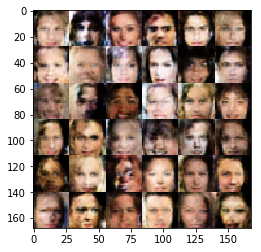

Epoch 1/1; d_loss: 0.4413; g_loss: 2.2091
Epoch 1/1; d_loss: 1.2801; g_loss: 0.4553
Epoch 1/1; d_loss: 1.0759; g_loss: 2.2809
Epoch 1/1; d_loss: 1.2765; g_loss: 0.4263
Epoch 1/1; d_loss: 1.2171; g_loss: 0.5331
Epoch 1/1; d_loss: 1.6937; g_loss: 0.2655
Epoch 1/1; d_loss: 1.3765; g_loss: 0.4790
Epoch 1/1; d_loss: 1.6318; g_loss: 0.2596
Epoch 1/1; d_loss: 1.0557; g_loss: 0.7338
Epoch 1/1; d_loss: 2.0846; g_loss: 0.1867


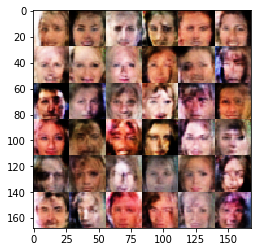

Epoch 1/1; d_loss: 1.0437; g_loss: 1.0796
Epoch 1/1; d_loss: 0.7853; g_loss: 1.1626
Epoch 1/1; d_loss: 0.8909; g_loss: 1.0165
Epoch 1/1; d_loss: 2.5211; g_loss: 0.1172
Epoch 1/1; d_loss: 0.5395; g_loss: 1.1533
Epoch 1/1; d_loss: 2.6597; g_loss: 0.0903
Epoch 1/1; d_loss: 0.4758; g_loss: 1.6834
Epoch 1/1; d_loss: 1.1828; g_loss: 0.8414
Epoch 1/1; d_loss: 0.8921; g_loss: 1.5923
Epoch 1/1; d_loss: 0.6666; g_loss: 1.2392


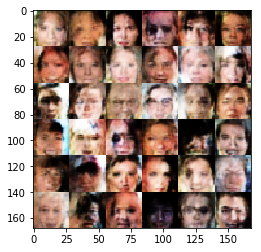

Epoch 1/1; d_loss: 0.3236; g_loss: 4.5741
Epoch 1/1; d_loss: 2.2912; g_loss: 0.1386
Epoch 1/1; d_loss: 2.0970; g_loss: 0.1609
Epoch 1/1; d_loss: 1.9694; g_loss: 0.2059
Epoch 1/1; d_loss: 0.2589; g_loss: 2.6523
Epoch 1/1; d_loss: 0.4079; g_loss: 1.5796
Epoch 1/1; d_loss: 0.4759; g_loss: 1.6250
Epoch 1/1; d_loss: 0.3928; g_loss: 1.6343
Epoch 1/1; d_loss: 0.6718; g_loss: 1.0821
Epoch 1/1; d_loss: 0.9019; g_loss: 3.6554


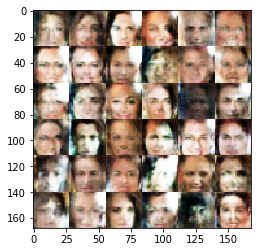

Epoch 1/1; d_loss: 1.0508; g_loss: 1.0565
Epoch 1/1; d_loss: 1.1549; g_loss: 1.4855
Epoch 1/1; d_loss: 0.6832; g_loss: 1.8526
Epoch 1/1; d_loss: 1.0494; g_loss: 0.8670
Epoch 1/1; d_loss: 0.3677; g_loss: 2.3017
Epoch 1/1; d_loss: 1.2304; g_loss: 0.6726
Epoch 1/1; d_loss: 2.3621; g_loss: 0.1330
Epoch 1/1; d_loss: 2.0304; g_loss: 0.1966
Epoch 1/1; d_loss: 1.3184; g_loss: 0.4201
Epoch 1/1; d_loss: 0.9363; g_loss: 0.8004


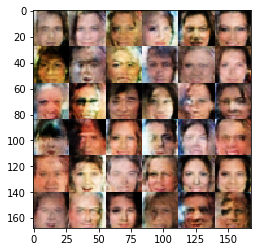

Epoch 1/1; d_loss: 1.1285; g_loss: 1.0827
Epoch 1/1; d_loss: 0.7346; g_loss: 1.3267
Epoch 1/1; d_loss: 1.5972; g_loss: 0.3243
Epoch 1/1; d_loss: 1.4141; g_loss: 0.4825
Epoch 1/1; d_loss: 1.0557; g_loss: 3.2014
Epoch 1/1; d_loss: 0.7497; g_loss: 1.1693
Epoch 1/1; d_loss: 0.8062; g_loss: 1.7494
Epoch 1/1; d_loss: 1.4533; g_loss: 1.6031
Epoch 1/1; d_loss: 0.7065; g_loss: 0.9703
Epoch 1/1; d_loss: 2.6954; g_loss: 0.1107


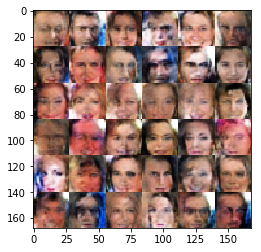

Epoch 1/1; d_loss: 0.5174; g_loss: 1.4796
Epoch 1/1; d_loss: 0.4179; g_loss: 1.7429
Epoch 1/1; d_loss: 1.6841; g_loss: 0.2899
Epoch 1/1; d_loss: 2.6099; g_loss: 0.1153
Epoch 1/1; d_loss: 1.2456; g_loss: 0.4869
Epoch 1/1; d_loss: 1.0540; g_loss: 1.9198
Epoch 1/1; d_loss: 2.7924; g_loss: 0.0863
Epoch 1/1; d_loss: 1.5468; g_loss: 0.4729
Epoch 1/1; d_loss: 0.8900; g_loss: 1.5815
Epoch 1/1; d_loss: 1.1774; g_loss: 0.5198


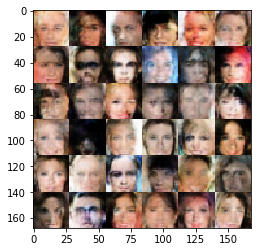

Epoch 1/1; d_loss: 1.2646; g_loss: 0.5396
Epoch 1/1; d_loss: 1.6637; g_loss: 0.3099
Epoch 1/1; d_loss: 2.1097; g_loss: 0.1685
Epoch 1/1; d_loss: 2.4482; g_loss: 0.1144
Epoch 1/1; d_loss: 1.4783; g_loss: 0.3657
Epoch 1/1; d_loss: 1.1090; g_loss: 1.1624
Epoch 1/1; d_loss: 1.8099; g_loss: 0.2220
Epoch 1/1; d_loss: 1.2934; g_loss: 0.6269
Epoch 1/1; d_loss: 2.4347; g_loss: 0.1267
Epoch 1/1; d_loss: 0.3517; g_loss: 1.9634


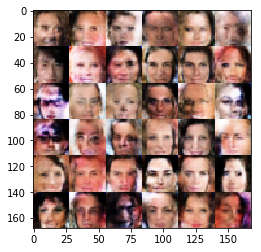

Epoch 1/1; d_loss: 0.3963; g_loss: 2.1767
Epoch 1/1; d_loss: 2.1785; g_loss: 0.1583
Epoch 1/1; d_loss: 0.8352; g_loss: 0.7789
Epoch 1/1; d_loss: 1.8651; g_loss: 0.2060
Epoch 1/1; d_loss: 0.3015; g_loss: 3.0130
Epoch 1/1; d_loss: 0.1068; g_loss: 6.1409
Epoch 1/1; d_loss: 0.8536; g_loss: 0.8264
Epoch 1/1; d_loss: 0.1364; g_loss: 2.8817
Epoch 1/1; d_loss: 0.9843; g_loss: 0.8698
Epoch 1/1; d_loss: 0.8285; g_loss: 1.9868


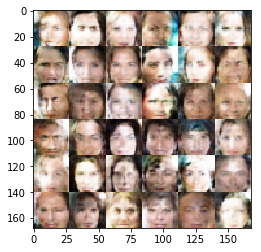

Epoch 1/1; d_loss: 1.0957; g_loss: 0.7434
Epoch 1/1; d_loss: 1.4164; g_loss: 0.5054
Epoch 1/1; d_loss: 0.4852; g_loss: 1.7569
Epoch 1/1; d_loss: 1.6668; g_loss: 3.6314
Epoch 1/1; d_loss: 1.5655; g_loss: 0.4024
Epoch 1/1; d_loss: 0.7755; g_loss: 0.9623
Epoch 1/1; d_loss: 0.5673; g_loss: 1.4189
Epoch 1/1; d_loss: 1.0709; g_loss: 0.5154
Epoch 1/1; d_loss: 0.4303; g_loss: 1.6414
Epoch 1/1; d_loss: 1.0926; g_loss: 0.7130


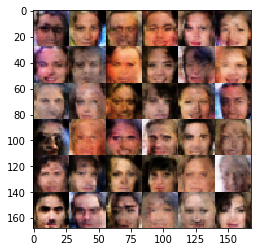

Epoch 1/1; d_loss: 2.5955; g_loss: 0.1008
Epoch 1/1; d_loss: 1.5954; g_loss: 0.3522
Epoch 1/1; d_loss: 0.6100; g_loss: 1.9046
Epoch 1/1; d_loss: 1.0117; g_loss: 1.0112
Epoch 1/1; d_loss: 0.6714; g_loss: 1.0773
Epoch 1/1; d_loss: 2.1366; g_loss: 0.1712
Epoch 1/1; d_loss: 2.0678; g_loss: 0.1932
Epoch 1/1; d_loss: 0.9184; g_loss: 2.1210
Epoch 1/1; d_loss: 0.3621; g_loss: 2.5060
Epoch 1/1; d_loss: 1.1511; g_loss: 0.9776


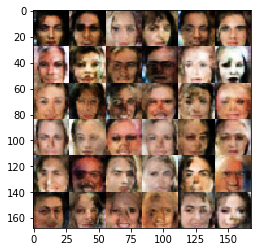

Epoch 1/1; d_loss: 0.8714; g_loss: 0.9332
Epoch 1/1; d_loss: 1.3080; g_loss: 0.4689
Epoch 1/1; d_loss: 1.0055; g_loss: 0.8256
Epoch 1/1; d_loss: 1.5520; g_loss: 0.3364
Epoch 1/1; d_loss: 1.3698; g_loss: 0.4021
Epoch 1/1; d_loss: 0.8313; g_loss: 1.4846
Epoch 1/1; d_loss: 0.7148; g_loss: 1.3340
Epoch 1/1; d_loss: 2.4835; g_loss: 0.0971
Epoch 1/1; d_loss: 2.2071; g_loss: 0.1495
Epoch 1/1; d_loss: 1.5583; g_loss: 0.8840


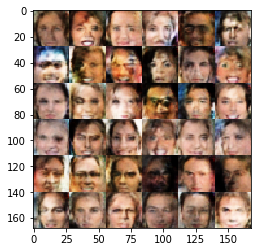

Epoch 1/1; d_loss: 0.4019; g_loss: 1.9271
Epoch 1/1; d_loss: 2.6522; g_loss: 0.1042
Epoch 1/1; d_loss: 0.7589; g_loss: 4.5429
Epoch 1/1; d_loss: 0.9229; g_loss: 1.0414
Epoch 1/1; d_loss: 2.2461; g_loss: 0.1331
Epoch 1/1; d_loss: 1.3564; g_loss: 0.5249
Epoch 1/1; d_loss: 1.9168; g_loss: 0.2132
Epoch 1/1; d_loss: 1.1373; g_loss: 0.5646
Epoch 1/1; d_loss: 0.2210; g_loss: 3.6031
Epoch 1/1; d_loss: 0.0861; g_loss: 4.5210


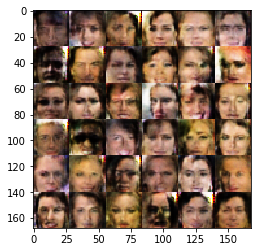

Epoch 1/1; d_loss: 0.1410; g_loss: 3.1197
Epoch 1/1; d_loss: 0.1746; g_loss: 3.0858
Epoch 1/1; d_loss: 1.0578; g_loss: 0.5497
Epoch 1/1; d_loss: 0.7393; g_loss: 1.3779
Epoch 1/1; d_loss: 0.9512; g_loss: 1.2390
Epoch 1/1; d_loss: 0.9737; g_loss: 1.7364
Epoch 1/1; d_loss: 1.6487; g_loss: 0.2768
Epoch 1/1; d_loss: 1.7584; g_loss: 0.3025
Epoch 1/1; d_loss: 3.1065; g_loss: 0.0650
Epoch 1/1; d_loss: 0.9896; g_loss: 0.8321


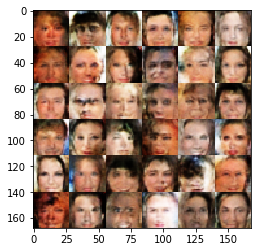

Epoch 1/1; d_loss: 1.7303; g_loss: 0.3074
Epoch 1/1; d_loss: 1.5002; g_loss: 0.5024
Epoch 1/1; d_loss: 1.6515; g_loss: 0.4976
Epoch 1/1; d_loss: 0.5942; g_loss: 2.7880
Epoch 1/1; d_loss: 1.6984; g_loss: 1.1327
Epoch 1/1; d_loss: 1.4777; g_loss: 0.3528
Epoch 1/1; d_loss: 1.0929; g_loss: 1.0837
Epoch 1/1; d_loss: 0.8512; g_loss: 0.8567
Epoch 1/1; d_loss: 1.5272; g_loss: 0.3172
Epoch 1/1; d_loss: 1.5306; g_loss: 0.3475


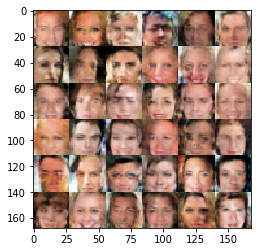

Epoch 1/1; d_loss: 2.2149; g_loss: 0.1703
Epoch 1/1; d_loss: 0.8320; g_loss: 1.0846
Epoch 1/1; d_loss: 1.0458; g_loss: 1.1903
Epoch 1/1; d_loss: 1.5888; g_loss: 0.3196
Epoch 1/1; d_loss: 1.4872; g_loss: 1.4273
Epoch 1/1; d_loss: 1.3034; g_loss: 0.4289
Epoch 1/1; d_loss: 1.3164; g_loss: 0.3806
Epoch 1/1; d_loss: 1.9745; g_loss: 0.2327
Epoch 1/1; d_loss: 1.3049; g_loss: 0.7536
Epoch 1/1; d_loss: 1.1746; g_loss: 0.6104


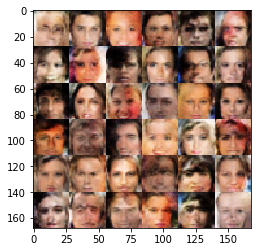

Epoch 1/1; d_loss: 1.7245; g_loss: 0.4658
Epoch 1/1; d_loss: 1.1775; g_loss: 1.6134
Epoch 1/1; d_loss: 1.0285; g_loss: 0.8149
Epoch 1/1; d_loss: 1.6896; g_loss: 0.2447
Epoch 1/1; d_loss: 1.2553; g_loss: 0.5609
Epoch 1/1; d_loss: 1.3473; g_loss: 0.6621
Epoch 1/1; d_loss: 0.6109; g_loss: 4.7603
Epoch 1/1; d_loss: 1.3952; g_loss: 0.4931
Epoch 1/1; d_loss: 1.1741; g_loss: 0.6795
Epoch 1/1; d_loss: 0.5724; g_loss: 2.3015


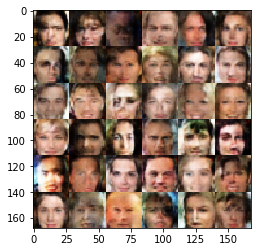

Epoch 1/1; d_loss: 0.8787; g_loss: 0.8129
Epoch 1/1; d_loss: 1.4217; g_loss: 0.4241
Epoch 1/1; d_loss: 1.4956; g_loss: 0.4144
Epoch 1/1; d_loss: 0.8509; g_loss: 0.9224
Epoch 1/1; d_loss: 1.0141; g_loss: 0.6812
Epoch 1/1; d_loss: 1.8881; g_loss: 0.2515
Epoch 1/1; d_loss: 2.1141; g_loss: 0.1838
Epoch 1/1; d_loss: 1.2546; g_loss: 0.4712
Epoch 1/1; d_loss: 1.5575; g_loss: 1.1211
Epoch 1/1; d_loss: 1.4106; g_loss: 0.8689


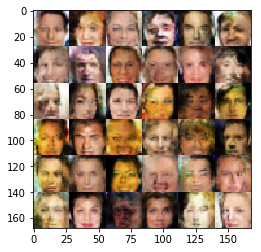

Epoch 1/1; d_loss: 1.9806; g_loss: 0.1950
Epoch 1/1; d_loss: 2.1980; g_loss: 0.1487
Epoch 1/1; d_loss: 2.1852; g_loss: 0.1478
Epoch 1/1; d_loss: 2.2176; g_loss: 0.1535
Epoch 1/1; d_loss: 0.9897; g_loss: 0.6859
Epoch 1/1; d_loss: 0.8064; g_loss: 1.4630
Epoch 1/1; d_loss: 0.8351; g_loss: 1.3014
Epoch 1/1; d_loss: 1.1169; g_loss: 1.4152
Epoch 1/1; d_loss: 2.9334; g_loss: 0.0780
Epoch 1/1; d_loss: 2.2608; g_loss: 0.1376


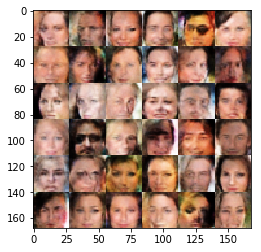

Epoch 1/1; d_loss: 2.4975; g_loss: 0.1036
Epoch 1/1; d_loss: 1.6205; g_loss: 0.3253
Epoch 1/1; d_loss: 2.8355; g_loss: 0.0710
Epoch 1/1; d_loss: 1.7515; g_loss: 0.3002
Epoch 1/1; d_loss: 1.2589; g_loss: 1.0503
Epoch 1/1; d_loss: 0.9476; g_loss: 1.1571
Epoch 1/1; d_loss: 1.6200; g_loss: 0.2684
Epoch 1/1; d_loss: 1.0711; g_loss: 0.5757
Epoch 1/1; d_loss: 1.9999; g_loss: 0.1802
Epoch 1/1; d_loss: 1.4541; g_loss: 0.5037


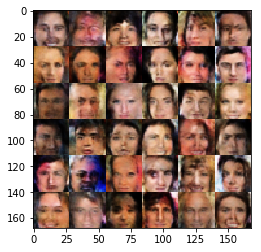

Epoch 1/1; d_loss: 1.7245; g_loss: 0.3188
Epoch 1/1; d_loss: 1.8197; g_loss: 0.2487
Epoch 1/1; d_loss: 1.8283; g_loss: 0.2234
Epoch 1/1; d_loss: 2.1660; g_loss: 0.1502
Epoch 1/1; d_loss: 1.3093; g_loss: 0.5931
Epoch 1/1; d_loss: 1.7068; g_loss: 0.4384
Epoch 1/1; d_loss: 1.5963; g_loss: 0.3142
Epoch 1/1; d_loss: 1.4336; g_loss: 0.6274
Epoch 1/1; d_loss: 1.8698; g_loss: 0.2216
Epoch 1/1; d_loss: 1.8423; g_loss: 0.2374


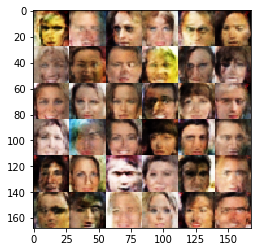

Epoch 1/1; d_loss: 1.4137; g_loss: 0.4660
Epoch 1/1; d_loss: 2.2706; g_loss: 0.1426
Epoch 1/1; d_loss: 2.4606; g_loss: 0.1202
Epoch 1/1; d_loss: 2.2824; g_loss: 0.1354
Epoch 1/1; d_loss: 2.2197; g_loss: 0.1493
Epoch 1/1; d_loss: 1.5289; g_loss: 0.3226
Epoch 1/1; d_loss: 1.5170; g_loss: 0.8962
Epoch 1/1; d_loss: 1.7667; g_loss: 0.4689
Epoch 1/1; d_loss: 1.5954; g_loss: 0.3731
Epoch 1/1; d_loss: 1.9149; g_loss: 0.1942


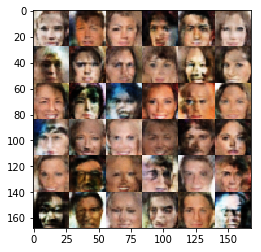

Epoch 1/1; d_loss: 2.3216; g_loss: 0.1213
Epoch 1/1; d_loss: 2.4845; g_loss: 0.1142
Epoch 1/1; d_loss: 1.0415; g_loss: 1.2316
Epoch 1/1; d_loss: 1.9565; g_loss: 0.2088
Epoch 1/1; d_loss: 1.8388; g_loss: 0.2481
Epoch 1/1; d_loss: 2.1080; g_loss: 0.1539
Epoch 1/1; d_loss: 1.8298; g_loss: 0.3018
Epoch 1/1; d_loss: 2.4702; g_loss: 1.6855
Epoch 1/1; d_loss: 1.8765; g_loss: 0.2729
Epoch 1/1; d_loss: 1.7775; g_loss: 0.2660


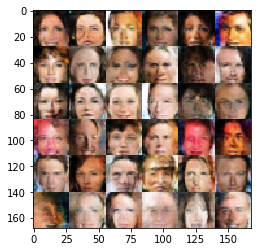

Epoch 1/1; d_loss: 2.3197; g_loss: 0.1303
Epoch 1/1; d_loss: 2.3627; g_loss: 0.1241
Epoch 1/1; d_loss: 2.0804; g_loss: 0.1895
Epoch 1/1; d_loss: 1.9084; g_loss: 0.2708
Epoch 1/1; d_loss: 1.8857; g_loss: 0.2517
Epoch 1/1; d_loss: 1.3098; g_loss: 0.4294
Epoch 1/1; d_loss: 2.2655; g_loss: 0.1441
Epoch 1/1; d_loss: 1.5919; g_loss: 0.4874
Epoch 1/1; d_loss: 0.9882; g_loss: 0.8446
Epoch 1/1; d_loss: 2.2995; g_loss: 0.1448


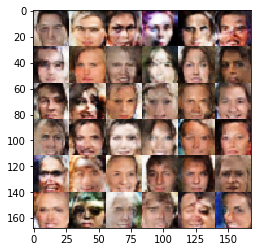

Epoch 1/1; d_loss: 2.3093; g_loss: 0.1315
Epoch 1/1; d_loss: 0.5678; g_loss: 2.0973
Epoch 1/1; d_loss: 2.1216; g_loss: 0.1901
Epoch 1/1; d_loss: 1.7298; g_loss: 0.3014
Epoch 1/1; d_loss: 1.6580; g_loss: 0.3258
Epoch 1/1; d_loss: 2.2298; g_loss: 0.1345
Epoch 1/1; d_loss: 2.7301; g_loss: 0.0887
Epoch 1/1; d_loss: 1.1992; g_loss: 1.6877
Epoch 1/1; d_loss: 2.7500; g_loss: 0.0766
Epoch 1/1; d_loss: 1.7121; g_loss: 0.2619


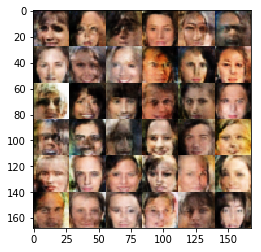

Epoch 1/1; d_loss: 1.2072; g_loss: 1.0053
Epoch 1/1; d_loss: 2.0841; g_loss: 0.1768
Epoch 1/1; d_loss: 2.0407; g_loss: 0.1879
Epoch 1/1; d_loss: 1.7667; g_loss: 0.2192
Epoch 1/1; d_loss: 2.2447; g_loss: 0.1690
Epoch 1/1; d_loss: 2.0022; g_loss: 0.2053
Epoch 1/1; d_loss: 1.2655; g_loss: 0.4872
Epoch 1/1; d_loss: 2.4650; g_loss: 0.1033
Epoch 1/1; d_loss: 1.4823; g_loss: 0.5845
Epoch 1/1; d_loss: 2.1701; g_loss: 0.2106


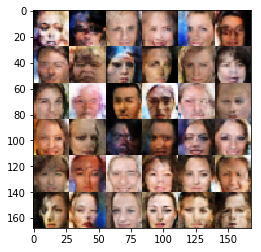

Epoch 1/1; d_loss: 1.1768; g_loss: 1.0996
Epoch 1/1; d_loss: 2.1062; g_loss: 0.1805
Epoch 1/1; d_loss: 0.8173; g_loss: 1.4214
Epoch 1/1; d_loss: 1.9560; g_loss: 0.2105
Epoch 1/1; d_loss: 2.4504; g_loss: 0.1300
Epoch 1/1; d_loss: 2.3024; g_loss: 0.1277
Epoch 1/1; d_loss: 2.0525; g_loss: 0.1757
Epoch 1/1; d_loss: 2.2825; g_loss: 0.1430
Epoch 1/1; d_loss: 1.4318; g_loss: 0.4117
Epoch 1/1; d_loss: 1.9461; g_loss: 0.2327


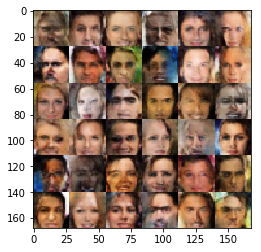

Epoch 1/1; d_loss: 2.0631; g_loss: 0.1763
Epoch 1/1; d_loss: 2.5958; g_loss: 0.1021
Epoch 1/1; d_loss: 1.9510; g_loss: 0.2023
Epoch 1/1; d_loss: 2.6563; g_loss: 0.1032
Epoch 1/1; d_loss: 2.2655; g_loss: 0.1323
Epoch 1/1; d_loss: 2.2849; g_loss: 0.1370
Epoch 1/1; d_loss: 2.5116; g_loss: 0.1174
Epoch 1/1; d_loss: 2.4247; g_loss: 0.1159
Epoch 1/1; d_loss: 2.0868; g_loss: 0.1903
Epoch 1/1; d_loss: 1.7729; g_loss: 0.3089


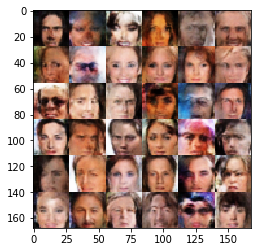

Epoch 1/1; d_loss: 1.7569; g_loss: 0.3036
Epoch 1/1; d_loss: 1.9027; g_loss: 0.2328
Epoch 1/1; d_loss: 2.3373; g_loss: 0.1368
Epoch 1/1; d_loss: 2.9510; g_loss: 0.0684
Epoch 1/1; d_loss: 2.1863; g_loss: 0.1513
Epoch 1/1; d_loss: 1.8641; g_loss: 0.3265
Epoch 1/1; d_loss: 2.2347; g_loss: 0.1438
Epoch 1/1; d_loss: 2.5518; g_loss: 0.0960
Epoch 1/1; d_loss: 2.6640; g_loss: 0.1052
Epoch 1/1; d_loss: 1.9072; g_loss: 0.2499


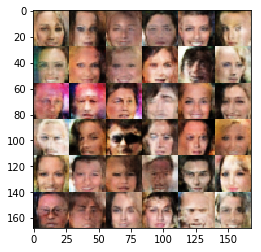

Epoch 1/1; d_loss: 2.0440; g_loss: 0.1875
Epoch 1/1; d_loss: 1.3998; g_loss: 1.0408
Epoch 1/1; d_loss: 2.4899; g_loss: 0.1075
Epoch 1/1; d_loss: 1.6525; g_loss: 0.4018
Epoch 1/1; d_loss: 2.0374; g_loss: 0.4599
Epoch 1/1; d_loss: 1.6044; g_loss: 0.5545
Epoch 1/1; d_loss: 1.6048; g_loss: 0.4376
Epoch 1/1; d_loss: 1.9986; g_loss: 0.1895
Epoch 1/1; d_loss: 1.1063; g_loss: 1.8150
Epoch 1/1; d_loss: 1.8472; g_loss: 0.2583


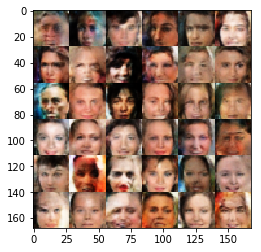

Epoch 1/1; d_loss: 1.4594; g_loss: 0.4626
Epoch 1/1; d_loss: 2.4800; g_loss: 0.1210
Epoch 1/1; d_loss: 2.0066; g_loss: 0.1753
Epoch 1/1; d_loss: 2.6108; g_loss: 0.0917
Epoch 1/1; d_loss: 2.5641; g_loss: 0.0956
Epoch 1/1; d_loss: 2.5303; g_loss: 0.0964
Epoch 1/1; d_loss: 1.4938; g_loss: 0.4337
Epoch 1/1; d_loss: 0.9724; g_loss: 0.8001
Epoch 1/1; d_loss: 2.7345; g_loss: 0.0876
Epoch 1/1; d_loss: 2.6332; g_loss: 0.0980


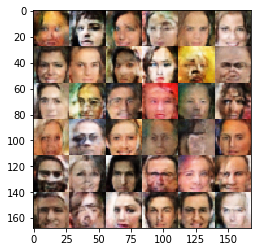

Epoch 1/1; d_loss: 2.4624; g_loss: 0.1115
Epoch 1/1; d_loss: 2.3569; g_loss: 0.1426
Epoch 1/1; d_loss: 2.1254; g_loss: 0.2202
Epoch 1/1; d_loss: 1.5111; g_loss: 0.3982
Epoch 1/1; d_loss: 2.2292; g_loss: 0.1356
Epoch 1/1; d_loss: 2.1710; g_loss: 0.1678
Epoch 1/1; d_loss: 1.6122; g_loss: 0.2957
Epoch 1/1; d_loss: 2.4534; g_loss: 0.1163
Epoch 1/1; d_loss: 2.4005; g_loss: 0.1671
Epoch 1/1; d_loss: 1.6999; g_loss: 0.4450


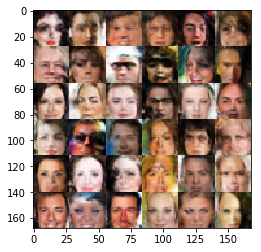

Epoch 1/1; d_loss: 2.5027; g_loss: 0.1030
Epoch 1/1; d_loss: 2.1310; g_loss: 0.2372
Epoch 1/1; d_loss: 1.8303; g_loss: 0.2676
Epoch 1/1; d_loss: 2.3312; g_loss: 0.1297
Epoch 1/1; d_loss: 1.6618; g_loss: 0.3229
Epoch 1/1; d_loss: 2.6966; g_loss: 0.0923
Epoch 1/1; d_loss: 2.2365; g_loss: 0.1448
Epoch 1/1; d_loss: 1.5127; g_loss: 0.8093
Epoch 1/1; d_loss: 2.4639; g_loss: 0.1065
Epoch 1/1; d_loss: 2.5110; g_loss: 0.1082


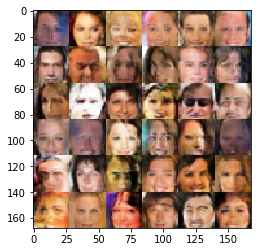

Epoch 1/1; d_loss: 1.2048; g_loss: 0.9524
Epoch 1/1; d_loss: 1.9555; g_loss: 0.1999
Epoch 1/1; d_loss: 2.3671; g_loss: 0.1417
Epoch 1/1; d_loss: 2.0775; g_loss: 0.2231
Epoch 1/1; d_loss: 2.1943; g_loss: 0.1632
Epoch 1/1; d_loss: 2.0407; g_loss: 0.2280
Epoch 1/1; d_loss: 1.5888; g_loss: 1.4071
Epoch 1/1; d_loss: 1.5318; g_loss: 0.3869
Epoch 1/1; d_loss: 1.8812; g_loss: 0.2821
Epoch 1/1; d_loss: 1.9933; g_loss: 0.2856


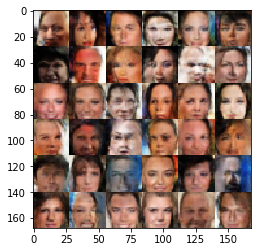

Epoch 1/1; d_loss: 1.9658; g_loss: 0.2031
Epoch 1/1; d_loss: 1.7690; g_loss: 0.3935
Epoch 1/1; d_loss: 1.7108; g_loss: 0.4012
Epoch 1/1; d_loss: 1.8250; g_loss: 0.2709
Epoch 1/1; d_loss: 2.3331; g_loss: 0.1232
Epoch 1/1; d_loss: 1.5366; g_loss: 0.4608
Epoch 1/1; d_loss: 1.9895; g_loss: 0.2506
Epoch 1/1; d_loss: 1.0919; g_loss: 1.1148
Epoch 1/1; d_loss: 1.8040; g_loss: 0.2475
Epoch 1/1; d_loss: 2.6527; g_loss: 0.0920


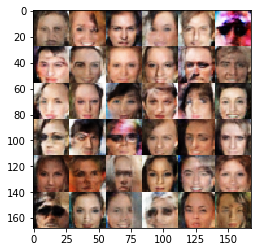

Epoch 1/1; d_loss: 1.3962; g_loss: 0.4375
Epoch 1/1; d_loss: 1.4906; g_loss: 0.6203
Epoch 1/1; d_loss: 1.8111; g_loss: 0.2594
Epoch 1/1; d_loss: 2.8282; g_loss: 0.0735
Epoch 1/1; d_loss: 2.0786; g_loss: 0.2338
Epoch 1/1; d_loss: 2.0516; g_loss: 0.2369
Epoch 1/1; d_loss: 2.3952; g_loss: 0.8505
Epoch 1/1; d_loss: 2.2345; g_loss: 0.3103
Epoch 1/1; d_loss: 1.4955; g_loss: 0.8563
Epoch 1/1; d_loss: 1.4442; g_loss: 0.6186


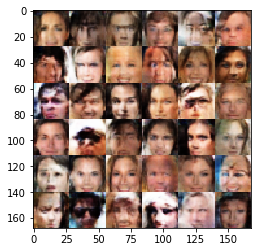

Epoch 1/1; d_loss: 1.7885; g_loss: 0.9959
Epoch 1/1; d_loss: 1.5689; g_loss: 0.7809
Epoch 1/1; d_loss: 1.7185; g_loss: 0.9266
Epoch 1/1; d_loss: 1.6178; g_loss: 0.5302
Epoch 1/1; d_loss: 1.5447; g_loss: 0.5185
Epoch 1/1; d_loss: 1.4758; g_loss: 0.6223
Epoch 1/1; d_loss: 1.4422; g_loss: 0.7593
Epoch 1/1; d_loss: 1.5281; g_loss: 0.5510
Epoch 1/1; d_loss: 1.4078; g_loss: 0.7501
Epoch 1/1; d_loss: 1.4094; g_loss: 0.5121


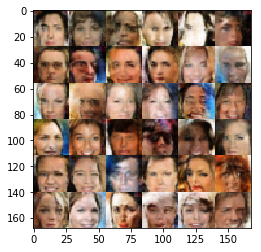

Epoch 1/1; d_loss: 1.3337; g_loss: 0.5738
Epoch 1/1; d_loss: 1.4197; g_loss: 1.0681
Epoch 1/1; d_loss: 1.5749; g_loss: 0.4003
Epoch 1/1; d_loss: 1.8246; g_loss: 0.8319
Epoch 1/1; d_loss: 1.9057; g_loss: 0.2300
Epoch 1/1; d_loss: 1.5306; g_loss: 0.4515
Epoch 1/1; d_loss: 2.1768; g_loss: 0.6232
Epoch 1/1; d_loss: 1.6155; g_loss: 0.6224
Epoch 1/1; d_loss: 2.1610; g_loss: 0.1462
Epoch 1/1; d_loss: 1.5231; g_loss: 0.4406


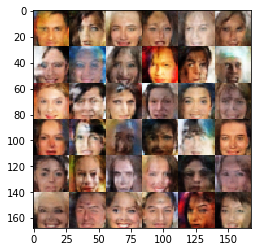

Epoch 1/1; d_loss: 2.4300; g_loss: 0.1282
Epoch 1/1; d_loss: 1.8461; g_loss: 0.2649
Epoch 1/1; d_loss: 2.4886; g_loss: 0.1012
Epoch 1/1; d_loss: 2.4459; g_loss: 0.1148
Epoch 1/1; d_loss: 1.5623; g_loss: 0.4268
Epoch 1/1; d_loss: 1.3513; g_loss: 0.4117
Epoch 1/1; d_loss: 0.8821; g_loss: 1.3213
Epoch 1/1; d_loss: 1.6243; g_loss: 0.5695
Epoch 1/1; d_loss: 2.4464; g_loss: 0.1168
Epoch 1/1; d_loss: 2.1423; g_loss: 0.1840


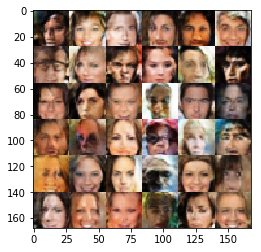

Epoch 1/1; d_loss: 1.8048; g_loss: 0.2822
Epoch 1/1; d_loss: 1.8239; g_loss: 0.2591
Epoch 1/1; d_loss: 2.3109; g_loss: 0.1434
Epoch 1/1; d_loss: 2.4926; g_loss: 0.1283
Epoch 1/1; d_loss: 2.4124; g_loss: 0.1311
Epoch 1/1; d_loss: 1.8739; g_loss: 0.2578
Epoch 1/1; d_loss: 2.0209; g_loss: 0.2174
Epoch 1/1; d_loss: 2.1227; g_loss: 0.3785
Epoch 1/1; d_loss: 1.7602; g_loss: 0.6595
Epoch 1/1; d_loss: 2.1623; g_loss: 0.2072


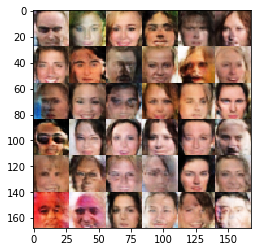

Epoch 1/1; d_loss: 1.4403; g_loss: 0.7403
Epoch 1/1; d_loss: 1.5728; g_loss: 0.5995
Epoch 1/1; d_loss: 1.9989; g_loss: 0.1826
Epoch 1/1; d_loss: 1.8180; g_loss: 0.3023
Epoch 1/1; d_loss: 2.5954; g_loss: 0.0965
Epoch 1/1; d_loss: 1.6604; g_loss: 0.3709
Epoch 1/1; d_loss: 2.1530; g_loss: 0.1439
Epoch 1/1; d_loss: 2.1981; g_loss: 0.1835
Epoch 1/1; d_loss: 3.1247; g_loss: 0.0521
Epoch 1/1; d_loss: 2.8403; g_loss: 0.0779


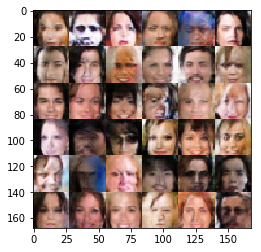

Epoch 1/1; d_loss: 1.4961; g_loss: 0.4283
Epoch 1/1; d_loss: 2.8826; g_loss: 0.1070
Epoch 1/1; d_loss: 2.2810; g_loss: 0.1451
Epoch 1/1; d_loss: 2.6727; g_loss: 0.1014
Epoch 1/1; d_loss: 1.6020; g_loss: 0.7444
Epoch 1/1; d_loss: 1.3160; g_loss: 0.7591
Epoch 1/1; d_loss: 2.2507; g_loss: 0.1602
Epoch 1/1; d_loss: 2.3459; g_loss: 0.1420
Epoch 1/1; d_loss: 2.4004; g_loss: 0.1167
Epoch 1/1; d_loss: 2.2540; g_loss: 0.1627


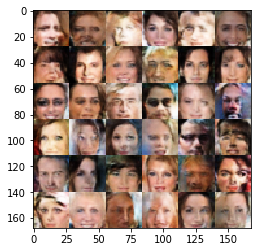

Epoch 1/1; d_loss: 2.4163; g_loss: 0.1227
Epoch 1/1; d_loss: 1.9911; g_loss: 0.2688
Epoch 1/1; d_loss: 1.6218; g_loss: 0.5476
Epoch 1/1; d_loss: 1.6842; g_loss: 0.2889
Epoch 1/1; d_loss: 1.6600; g_loss: 0.4355
Epoch 1/1; d_loss: 2.5662; g_loss: 0.1519
Epoch 1/1; d_loss: 1.9702; g_loss: 0.2751
Epoch 1/1; d_loss: 1.5340; g_loss: 0.4817
Epoch 1/1; d_loss: 1.5551; g_loss: 0.5388
Epoch 1/1; d_loss: 2.1329; g_loss: 0.2497


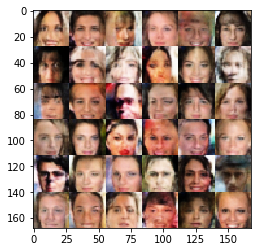

Epoch 1/1; d_loss: 2.3582; g_loss: 0.1296
Epoch 1/1; d_loss: 2.5524; g_loss: 0.1071
Epoch 1/1; d_loss: 2.5519; g_loss: 0.0945
Epoch 1/1; d_loss: 1.2639; g_loss: 1.0132
Epoch 1/1; d_loss: 2.4357; g_loss: 0.1146
Epoch 1/1; d_loss: 1.2324; g_loss: 1.5450
Epoch 1/1; d_loss: 1.5754; g_loss: 0.4319
Epoch 1/1; d_loss: 1.8525; g_loss: 0.2262
Epoch 1/1; d_loss: 2.3002; g_loss: 0.1491
Epoch 1/1; d_loss: 2.0464; g_loss: 0.1816


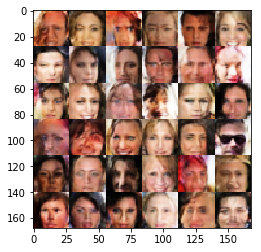

Epoch 1/1; d_loss: 2.6179; g_loss: 0.1061
Epoch 1/1; d_loss: 2.2407; g_loss: 0.1646
Epoch 1/1; d_loss: 1.6381; g_loss: 0.3720
Epoch 1/1; d_loss: 1.7171; g_loss: 0.6704
Epoch 1/1; d_loss: 1.4816; g_loss: 0.4027
Epoch 1/1; d_loss: 1.5951; g_loss: 0.3853
Epoch 1/1; d_loss: 2.2268; g_loss: 0.1408
Epoch 1/1; d_loss: 1.5830; g_loss: 0.7898
Epoch 1/1; d_loss: 1.6563; g_loss: 0.5888
Epoch 1/1; d_loss: 2.6461; g_loss: 0.0991


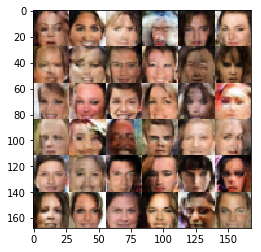

Epoch 1/1; d_loss: 2.4194; g_loss: 0.1323
Epoch 1/1; d_loss: 1.5865; g_loss: 0.3645
Epoch 1/1; d_loss: 1.6367; g_loss: 0.3842
Epoch 1/1; d_loss: 1.6302; g_loss: 0.3524
Epoch 1/1; d_loss: 2.2880; g_loss: 0.1423
Epoch 1/1; d_loss: 2.2051; g_loss: 0.1730
Epoch 1/1; d_loss: 1.5816; g_loss: 0.4997
Epoch 1/1; d_loss: 1.8322; g_loss: 0.2624
Epoch 1/1; d_loss: 2.5509; g_loss: 0.1121
Epoch 1/1; d_loss: 1.6054; g_loss: 0.5161


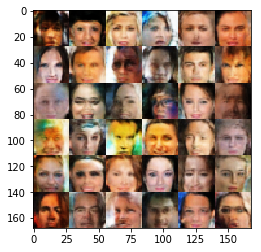

Epoch 1/1; d_loss: 2.3153; g_loss: 0.1637
Epoch 1/1; d_loss: 2.5698; g_loss: 0.1039
Epoch 1/1; d_loss: 1.7466; g_loss: 0.4109


In [27]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.